# Init

In [4]:
!sage -pip install -q plotly tqdm

In [5]:
from tqdm.auto import tqdm
import plotly.express as px

In [19]:
%display latex

# https://github.com/jupyter-lsp/jupyterlab-lsp/issues/910#issuecomment-1465356625

# Backprojection

## Extrinsics

In [2]:
f1, f2 = var("f1 f2")
F = diagonal_matrix([f1, f2, 1])

In [3]:
RT = matrix(SR, [[f"R_{i}{j}" for i in range(1, 4)] + [f"t_{j}"] for j in range(1, 4)])

In [4]:
P = F * RT

In [5]:
F, RT, P

(
[f1  0  0]  [R_11 R_21 R_31  t_1]  [R_11*f1 R_21*f1 R_31*f1  f1*t_1]
[ 0 f2  0]  [R_12 R_22 R_32  t_2]  [R_12*f2 R_22*f2 R_32*f2  f2*t_2]
[ 0  0  1], [R_13 R_23 R_33  t_3], [   R_13    R_23    R_33     t_3]
)

In [6]:
# [a == b for a, b in zip((F*F.T).list() , (RT*RT.T).list())]

## Intrinsics

In [7]:
alpha, s, u1, u2 = var("alpha s u1 u2")
u = vector([u1, u2, 1])
e = vector(list(var("e_x e_y")) + [1])
T = matrix.identity(SR, 3)
T[:, 2] = -e

In [8]:
A = diagonal_matrix([1 / alpha, 1, 1]) * diagonal_matrix([1 / s, 1 / s, 1]) * T
A

[   1/(alpha*s)              0 -e_x/(alpha*s)]
[             0            1/s         -e_y/s]
[             0              0             -1]

## 3D point

In [9]:
X = vector(SR, [var(f"X_{i}") for i in range(1, 3)] + [0, 1])
X

(X_1, X_2, 0, 1)

## Distortion

In [10]:
lambda_1, lambda_2, lambda_3 = var("lambda_1 lambda_2 lambda_3", domain="real")


def psi(r, n=2):
    assert 1 <= n <= 3
    ret = 1 + lambda_1 * r ^ 2
    if n >= 2:
        ret += lambda_2 * r ^ 4
    if n == 3:
        ret += lambda_3 * r ^ 6
    return ret


r = lambda u: norm(u[0:2])
g = lambda u, n=2: vector([u[0], u[1], psi(r(u), n)])

In [11]:
g(A * u)

(-e_x/(alpha*s) + u1/(alpha*s), -e_y/s + u2/s, (abs(-e_y/s + u2/s)^2 + abs(-e_x/(alpha*s) + u1/(alpha*s))^2)^2*lambda_2 + (abs(-e_y/s + u2/s)^2 + abs(-e_x/(alpha*s) + u1/(alpha*s))^2)*lambda_1 + 1)

## Backprojection

In [12]:
gamma = var("gamma")

In [13]:
# https://github.com/sagemath/sage/issues/35264
backproj = gamma * g(A * u), P * X

display(backproj[0])
display(backproj[1])

(-gamma*(e_x/(alpha*s) - u1/(alpha*s)), -gamma*(e_y/s - u2/s), ((abs(-e_y/s + u2/s)^2 + abs(-e_x/(alpha*s) + u1/(alpha*s))^2)^2*lambda_2 + (abs(-e_y/s + u2/s)^2 + abs(-e_x/(alpha*s) + u1/(alpha*s))^2)*lambda_1 + 1)*gamma)

(R_11*X_1*f1 + R_21*X_2*f1 + f1*t_1, R_12*X_1*f2 + R_22*X_2*f2 + f2*t_2, R_13*X_1 + R_23*X_2 + t_3)

In [14]:
[lhs == rhs for lhs, rhs in zip(gamma * g(A * u), P * X)]

[-gamma*(e_x/(alpha*s) - u1/(alpha*s)) == R_11*X_1*f1 + R_21*X_2*f1 + f1*t_1,
 -gamma*(e_y/s - u2/s) == R_12*X_1*f2 + R_22*X_2*f2 + f2*t_2,
 ((abs(-e_y/s + u2/s)^2 + abs(-e_x/(alpha*s) + u1/(alpha*s))^2)^2*lambda_2 + (abs(-e_y/s + u2/s)^2 + abs(-e_x/(alpha*s) + u1/(alpha*s))^2)*lambda_1 + 1)*gamma == R_13*X_1 + R_23*X_2 + t_3]

# Inverse backprojection

In [80]:
u

(u_1, u_2, 1)

In [146]:
x = gamma * g(u, 2)
x

(gamma*u_1, gamma*u_2, ((abs(u_1)^2 + abs(u_2)^2)^2*lambda_2 + (abs(u_1)^2 + abs(u_2)^2)*lambda_1 + 1)*gamma)

In [142]:
t = var("t", domain="real")
t

t

In [152]:
(t * r(x), t * x[2])

(sqrt(abs(gamma*u_1)^2 + abs(gamma*u_2)^2)*t,
 ((abs(u_1)^2 + abs(u_2)^2)^2*lambda_2 + (abs(u_1)^2 + abs(u_2)^2)*lambda_1 + 1)*gamma*t)

In [148]:
eq = psi(t * r(x)) == t * x[2]
eq

(abs(gamma*u_1)^2 + abs(gamma*u_2)^2)^2*lambda_2*t^4 + (abs(gamma*u_1)^2 + abs(gamma*u_2)^2)*lambda_1*t^2 + 1 == ((abs(u_1)^2 + abs(u_2)^2)^2*lambda_2 + (abs(u_1)^2 + abs(u_2)^2)*lambda_1 + 1)*gamma*t

In [114]:
eqs = [a == b for a, b in zip(gamma * g(u), x)]
eqs

[gamma*u_1 == gamma*u_1,
 gamma*u_2 == gamma*u_2,
 ((abs(u_1)^2 + abs(u_2)^2)^2*lambda_2 + (abs(u_1)^2 + abs(u_2)^2)*lambda_1 + 1)*gamma == ((abs(u_1)^2 + abs(u_2)^2)^2*lambda_2 + (abs(u_1)^2 + abs(u_2)^2)*lambda_1 + 1)*gamma]

In [113]:
solve(eqs, u[0], u[1], gamma)

[[u_1 == r40, u_2 == r39, gamma == r38]]

In [77]:
u_ = u.subs({u_1: 0.2, u_2: 0.3})

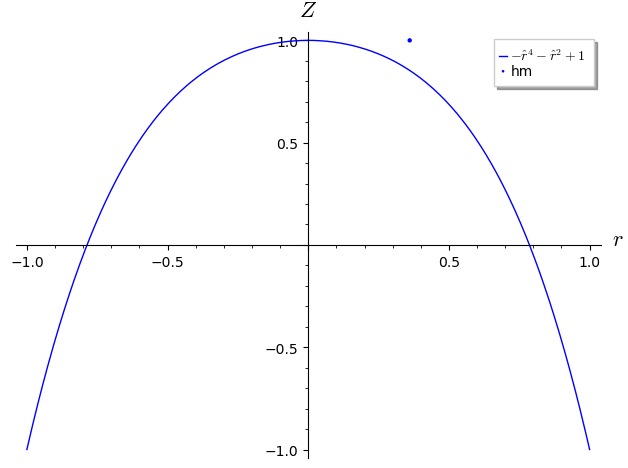

In [78]:
r_hat = var("r_hat", latex_name=r"\hat{r}", domain="real")


eq = psi(r_hat).subs({lambda_1: -1, lambda_2: -1})
psi_plot = plot(eq, axes_labels=["$r$", "$Z$"], legend_label=f"${latex(eq)}$")
u_plot = point((r(u_), u_[2]), legend_label="u")
u_hat_plot = point((r(u_hat_), u_[2]), legend_label="u")

sum([psi_plot, x_])

## Solve for $\hat{r}$

In [17]:
r_hat = var("r_hat", latex_name=r"\hat{r}", domain="real")

solve(psi(r_hat, 1) == 2, r_hat)

[r_hat == -1/sqrt(lambda_1), r_hat == 1/sqrt(lambda_1)]

In [18]:
solve(psi(r_hat, 2) == 2, r_hat)

[r_hat == -sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2), r_hat == sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2), r_hat == -sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2), r_hat == sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2)]

In [19]:
solve(psi(r_hat, 3) == 2, r_hat)

[r_hat == -1/3*sqrt(9*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_2*lambda_3 + lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3))/lambda_3, r_hat == 1/3*sqrt(9*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_2*lambda_3 + lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3))/lambda_3, r_hat == -1/3*sqrt(9/2*I*sqrt(3)*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 9/2*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 1/2*I*sqrt(3)*lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) + 3/2*I*sqrt(3)*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_2*lambda_3 - 1/2*lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) + 3/2*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3))/lambda_3, r_hat == 1/3*sqrt(9/2*I*sqrt(3)*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 9/2*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) - 1/2*I*sqrt(3)*lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3 + 6*lambda_1*lambda_2*lambda_3 + 9*lambda_3^2)/lambda_3^2)^(1/3) + 3/2*I*sqrt(3)*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*la

## Test the closed-form solutions for $w = 2$

In [20]:
print(solve(psi(r_hat) == 2, r_hat))

[
r_hat == -sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2),
r_hat == sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2),
r_hat == -sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2),
r_hat == sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2)
]


In [21]:
eqs = [
    lambda l1, l2: -sqrt(-1 / 2 * l1 / l2 + 1 / 2 * sqrt(l1**2 + 4 * l2) / l2),
    lambda l1, l2: sqrt(-1 / 2 * l1 / l2 + 1 / 2 * sqrt(l1**2 + 4 * l2) / l2),
    lambda l1, l2: -sqrt(-1 / 2 * l1 / l2 - 1 / 2 * sqrt(l1**2 + 4 * l2) / l2),
    lambda l1, l2: sqrt(-1 / 2 * l1 / l2 - 1 / 2 * sqrt(l1**2 + 4 * l2) / l2),
]

[r_hat == eq(lambda_1, lambda_2) for eq in eqs]

[r_hat == -sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2),
 r_hat == sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2),
 r_hat == -sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2),
 r_hat == sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2)/lambda_2)]

## Check where the solutions exist

In [22]:
values = []

l1_range = (-5, 6)
l2_range = l1_range
for l1 in range(*l1_range):
    vals = []
    for l2 in range(*l2_range):
        rs = solve(psi(r_hat).subs({lambda_1: l1, lambda_2: l2}) == 2, r_hat)
        rs = list(filter(lambda r: r.rhs() > 0, rs))
        vals.append(-1 if len(rs) == 0 else rs[0].rhs())
    values.append(vals)

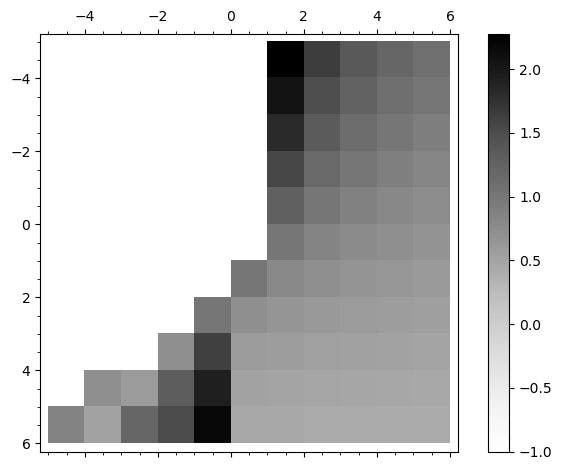

In [23]:
matrix_plot(matrix(values), xrange=l2_range, yrange=l1_range, colorbar=True)

## Check where the solutions exist for each equation separately

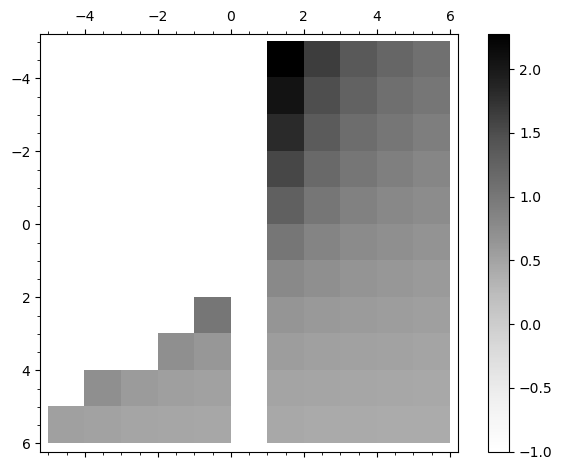

In [24]:
values = []

for l1 in range(*l1_range):
    vals = []
    for l2 in range(*l2_range):
        rs = []
        for eq_i, eq in enumerate(eqs):
            try:
                # rs = [eq(l1, l2)]
                rs.append(eq(l1, l2))
            except ZeroDivisionError:
                # rs = []
                pass
        rs = list(filter(lambda r: r > 0 and r in RR, rs))
        vals.append(-1 if len(rs) == 0 else rs[0])
        if len(rs) != 0:
            assert psi(rs[0]).subs({lambda_1: l1, lambda_2: l2}) == 2
    values.append(vals)

display(matrix_plot(matrix(values), xrange=l2_range, yrange=l1_range, colorbar=True))

Eq_0


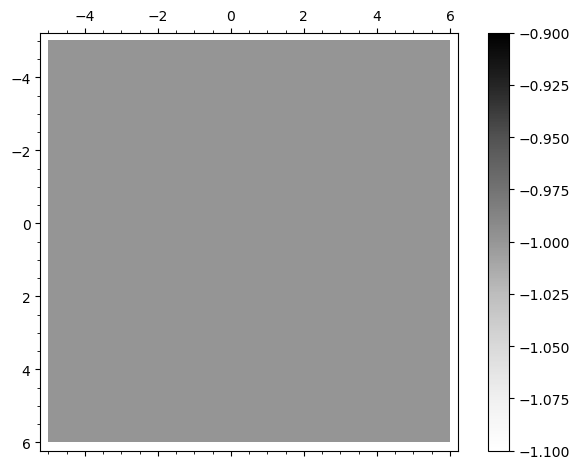

Eq_1


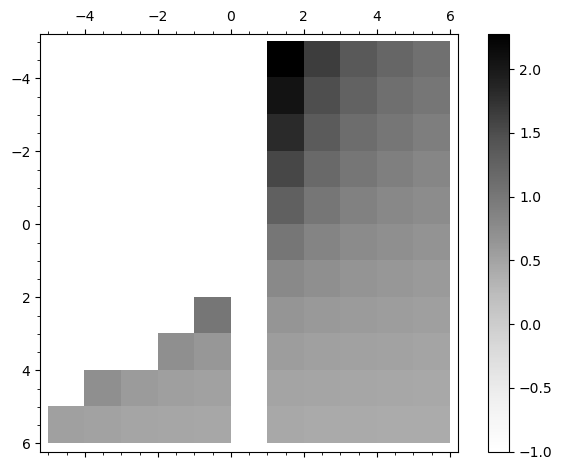

Eq_2


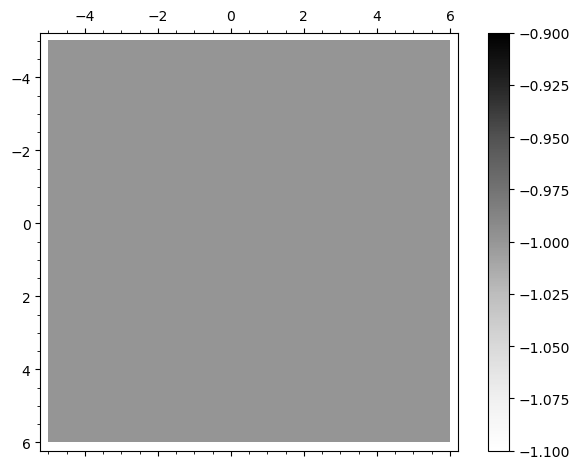

Eq_3


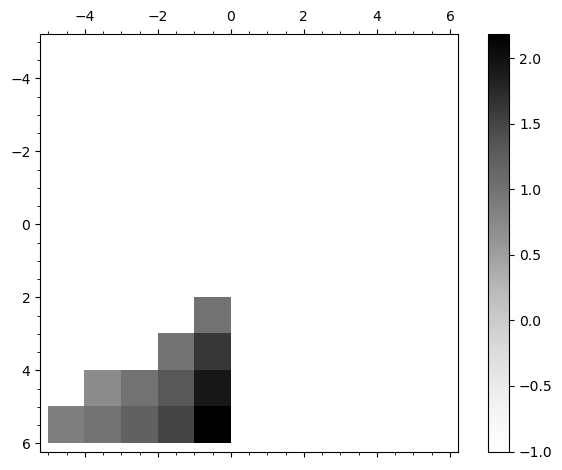

In [25]:
for eq_i, eq in enumerate(eqs):
    values = []

    for l1 in range(*l1_range):
        vals = []
        for l2 in range(*l2_range):
            try:
                rs = [eq(l1, l2)]
            except ZeroDivisionError:
                rs = []
            rs = list(filter(lambda r: r > 0 and r in RR, rs))
            vals.append(-1 if len(rs) == 0 else rs[0])
            if len(rs) != 0:
                assert psi(rs[0]).subs({lambda_1: l1, lambda_2: l2}) == 2
        values.append(vals)

    print(f"Eq_{eq_i}")
    display(
        matrix_plot(matrix(values), xrange=l2_range, yrange=l1_range, colorbar=True)
    )

## Solve for $\hat{r}$ for any $w$

In [26]:
w = var("w")

solve(psi(r_hat, 1) == w, r_hat)

[r_hat == -sqrt(w/lambda_1 - 1/lambda_1), r_hat == sqrt(w/lambda_1 - 1/lambda_1)]

In [27]:
solve(psi(r_hat, 2) == w, r_hat)

[r_hat == -sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2*w - 4*lambda_2)/lambda_2), r_hat == sqrt(-1/2*lambda_1/lambda_2 + 1/2*sqrt(lambda_1^2 + 4*lambda_2*w - 4*lambda_2)/lambda_2), r_hat == -sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2*w - 4*lambda_2)/lambda_2), r_hat == sqrt(-1/2*lambda_1/lambda_2 - 1/2*sqrt(lambda_1^2 + 4*lambda_2*w - 4*lambda_2)/lambda_2)]

In [28]:
solve(psi(r_hat, 3) == w, r_hat)

[r_hat == -1/3*sqrt(9*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_2*lambda_3 + lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3))/lambda_3, r_hat == 1/3*sqrt(9*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_2*lambda_3 + lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3))/lambda_3, r_hat == -1/3*sqrt(9/2*I*sqrt(3)*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 9/2*lambda_3^2*(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 1/2*I*sqrt(3)*lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) + 3/2*I*sqrt(3)*lambda_1*lambda_3/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3) - 3*lambda_2*lambda_3 - 1/2*lambda_2^2/(-1/27*lambda_2^3/lambda_3^3 + 1/6*lambda_1*lambda_2/lambda_3^2 + 1/2*w/lambda_3 - 1/2/lambda_3 + 1/6*sqrt(-1/3*lambda_1^2*lambda_2^2 + 4/3*lambda_1^3*lambda_3 - 4/3*lambda_2^3*w + 6*lambda_1*lambda_2*lambda_3*w + 9*lambda_3^2*w^2 + 4/3*lambda_2^3 - 6*lambda_1*lambda_2*lambda_3 - 18*lambda_3^2*w + 9*lambda_3^2)/lambda_3^2)^(1/3

## Find intersection with the $\psi(r)$

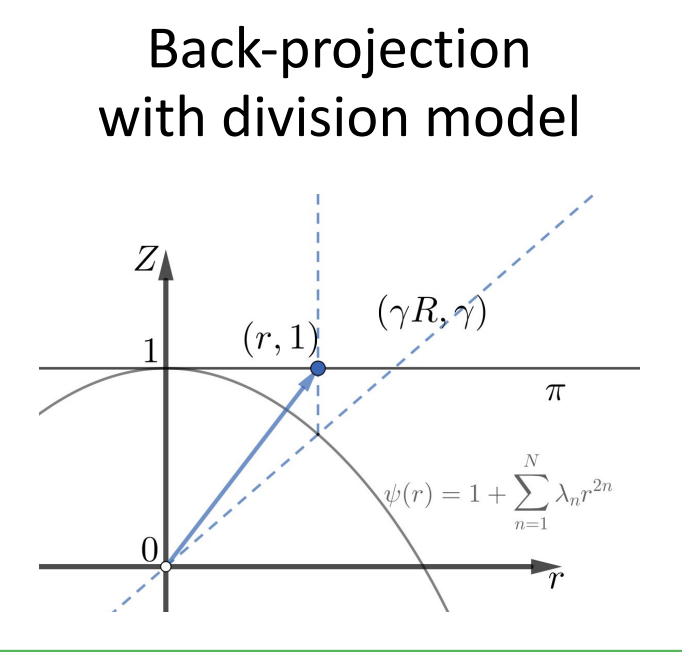

-2*r_hat^4 - 2*r_hat^2 + 1

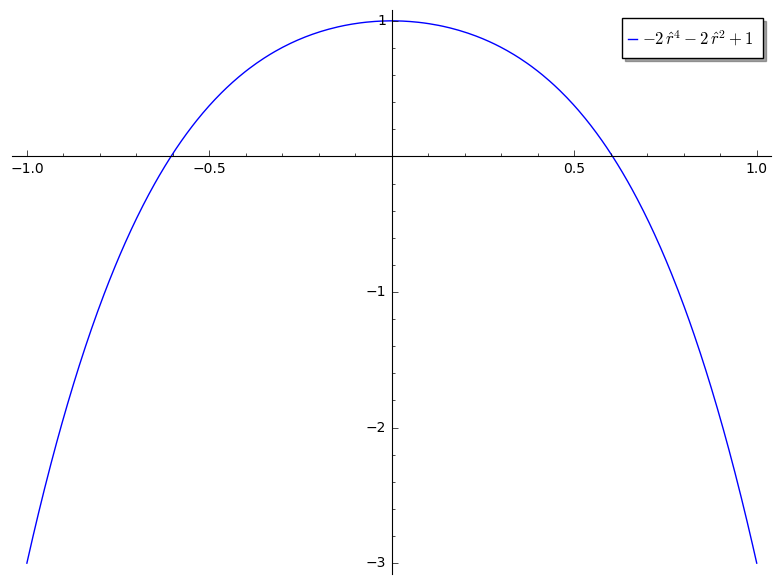

In [67]:
eq = psi(r_hat).subs({lambda_1: -2, lambda_2: -2})
plot(eq, legend_label=f"${latex(eq)}$")

In [68]:
X_ = vector(SR, [var(f"X_{i}") for i in range(1, 4)])
X_

(X_1, X_2, X_3)

In [71]:
l = var("l", latex_name="\\lambda")
l

l

In [74]:
l * X_[2] == psi(r_hat).subs({r_hat: sqrt(X_[0] ** 2 + X_[1] ** 2)})

X_3*l == (X_1^2 + X_2^2)^2*lambda_2 + (X_1^2 + X_2^2)*lambda_1 + 1

In [77]:
solve(l * X_[2] == psi(r_hat).subs({r_hat: sqrt(X_[0] ** 2 + X_[1] ** 2)}), l)

[l == ((X_1^2 + X_2^2)*lambda_1 + (X_1^4 + 2*X_1^2*X_2^2 + X_2^4)*lambda_2 + 1)/X_3]